In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import pickle
import collections
import glob
import json
import utils

import matplotlib.pyplot as plt
sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette('colorblind')

In [2]:
tool_to_domain = {'biobloom': 'nt', 
                  'blastn': 'nt', 
                  'bwa': 'nt', 
                  'bowtie2': 'nt',
                  'groot': 'nt',
                  'hmmsearch_nt': 'nt',
                  'blastp': 'aa', 
                  'blastx': 'nt_to_aa',
                  'paladin': 'nt_to_aa', 
                  'diamond_blastx': 'nt_to_aa', 
                  'diamond_blastp': 'aa',
                  'hmmsearch_aa': 'aa'}

tool_to_paradigm = {'biobloom': 'k-mer', 
                  'blastn': 'BLAST', 
                  'bwa': 'BWT', 
                  'bowtie2': 'BWT',
                  'groot': 'k-mer',
                  'hmmsearch_nt': 'HMM',
                  'blastp': 'BLAST', 
                  'blastx': 'BLAST',
                  'paladin': 'BWT', 
                  'diamond_blastx': 'BLAST', 
                  'diamond_blastp': 'BLAST',
                  'hmmsearch_aa': 'HMM'}

card = utils.CARD('../data/CARD_canonical/card.json')

## Family Level Summaries

In [3]:
TOTAL_SEQUENCES = 30317435

def hmm_summarise(fp, domain,tool, params, paradigm, card):
    
    df = pd.read_csv(fp)
    df = df.rename(columns={'Unnamed: 0': "Family"}).set_index("Family")
    
    df['domain'] = domain
    df['tool'] = tool
    df['param'] = params
    df['paradigm'] = paradigm
    
    df['correct_family_prop'] = df['correct_family'] / df['totals']
    df['wrong_family_prop'] = df['wrong_family'] / df['totals']
    
    df['missed_prop'] = df['missed'] / df['totals']
    
    # fp as a proportion of all hits to that family i.e. correct, AMR but different AMR, and not AMR (fp) 
    df['fp_prop'] = df['false_positive'] / (df['false_positive'] + df['correct_family'] + df['wrong_family'])
    
    df = df.reset_index()
    df = df[['Family', 'domain', 'tool', 'param', 'paradigm', 'correct_family_prop', 
             'wrong_family_prop', 'missed_prop', 'fp_prop']]
    
    return df


def family_summarise(fp, domain,tool, params, paradigm, card):
    
    df = pd.read_csv(fp)
    df = df.rename(columns={'Unnamed: 0': "ARO"})
    df['ARO'] = df['ARO'].astype(str)
    
    # remove the private models without families
    df = df[~df['ARO'].isin(['3000489', '3000309', '3002818'])]
    
    df['Family'] = df['ARO'].apply(lambda x: card.aro_to_gene_family[x])
    
    if df[df['missed'] < 0].shape[0] != 0:
        assert False
    
    
    df = df.groupby('Family').sum()
    
    df['domain'] = domain
    df['tool'] = tool
    df['param'] = params
    df['paradigm'] = paradigm
    
    df['correct_family'] = df['correct_aro'] + df['wrong_aro_correct_family']
    df['wrong_family'] = df['wrong_aro_wrong_family'] 
    
    df['correct_family_prop'] = df['correct_family'] / df['totals']
    df['wrong_family_prop'] = df['wrong_family'] / df['totals']
    
    df['missed_prop'] = df['missed'] / df['totals']
    
    # fp as a proportion of all hits to that family i.e. correct, AMR but different AMR, and not AMR (fp) 
    df['fp_prop'] = df['false_positive'] / (df['false_positive'] + df['correct_family'] + df['wrong_family'])
    
    df = df.reset_index()
    
    df = df[['Family', 'domain', 'tool', 'param', 'paradigm', 'correct_family_prop', 
             'wrong_family_prop', 'missed_prop', 'fp_prop']]
    
    return df

In [16]:
family_results = []

for tool_run in glob.glob('tool_runs/*.csv'):
    tool = tool_run.split('/')[1]
    
    # biobloom only has overall filter level summaries
    if tool.startswith('biobloom'):
        continue
    
    if tool.startswith('diamond') or tool.startswith('hmmsearch'):
        params = '_'.join(tool.split('_')[2:]).replace('.csv', '')
        tool = '_'.join(tool.split('_')[:2])    
    else:
        params = '_'.join(tool.split('_')[1:]).replace('.csv', '')
        tool = tool.split('_')[0]
    
    domain = tool_to_domain[tool]
    paradigm = tool_to_paradigm[tool]
    
    
    
    if tool.startswith('hmmsearch'):
        family_results.append(hmm_summarise(tool_run, domain, tool, params, paradigm, card))
    else:
        family_results.append(family_summarise(tool_run, domain, tool, params, paradigm, card))
        
                              
                              
family_results = pd.concat(family_results)
family_results = family_results.replace({'aa': 'Protein Query/DB',
                                   'nt': 'DNA Query/DB',
                                   'nt_to_aa': 'DNA Query, Protein DB'})

name_tidy = {'blastn': 'BLASTN', 'bwa': 'BWA-MEM', 'bowtie2': "Bowtie2", 'blastx': "BLASTX", 
             'diamond_blastx': "DIAMOND-BLASTX", 'paladin': "PALADIN", 'blastp': "BLASTP", 
             'diamond_blastp': "DIAMOND-BLASTP", 'hmmsearch_nt': 'HMMsearch-NT', 'hmmsearch_aa': 'HMMsearch-AA'}
family_results['tool'] = family_results['tool'].replace(name_tidy)


In [17]:
family_results.groupby(['tool', 'param'])['correct_family_prop'].describe().sort_values('mean')

count      mean       std       min  \
tool   param                                                            
groot  card_k5_s128_j090_default  193.0  0.018486  0.015850  0.000000   
       card_k7_s128_j090_default  193.0  0.018614  0.016716  0.000000   
       card_k5_s256_j090_default  193.0  0.018619  0.015935  0.000000   
       card_k9_s128_j090_default  192.0  0.018716  0.017066  0.000000   
       card_k9_s256_j090_default  193.0  0.018846  0.017039  0.000000   
...                                 ...       ...       ...       ...   
BLASTN default_min50              246.0  0.993340  0.050694  0.256639   
BLASTX default_1e-10              246.0  0.993767  0.043902  0.380000   
       default_min50              246.0  0.993836  0.043895  0.380000   
BLASTP default_1e-10              246.0  0.995133  0.021664  0.733333   
       default_min50              246.0  0.995144  0.021484  0.741667   

                                       25%       50%       75%  max  
tool   param                                                         
groot  card_k5_s128_j090_default  0.006250  0.014653  0.028571  0.1  
       card_k7_s128_j090_default  0.006098  0.014532  0.028571  0.1  
       card_k5_s256_j090_default  0.006198  0.015385  0.027500  0.1  
       card_k9_s128_j090_default  0.006272  0.014285  0.026944  0.1  
       card_k9_s256_j090_default  0.006250  0.014998  0.028571  0.1  
...                                    ...       ...       ...  ...  
BLASTN default_min50              1.000000  1.000000  1.000000  1.0  
BLASTX default_1e-10              0.999954  1.000000  1.000000  1.0  
       default_min50              1.000000  1.000000  1.000000  1.0  
BLASTP default_1e-10              0.999236  1.000000  1.000000  1.0  
       default_min50              0.999236  1.000000  1.000000  1.0  

[85 rows x 8 columns]

In [18]:
# calculate multiclass mathews correlation coefficient per tool and parameter 
#setting to pick the 'best settings' for each tool
# this would be better but let's just do the dumb thing i.e. max mean correct family_prop as we are assessing best accuracy here
# not fp and filtering

In [19]:
# get settings for each tool that had the maximum correct family per 
top_by_correct_fam = family_results.groupby(['tool', 'param'])['correct_family_prop'].mean().reset_index()
top_by_correct_fam_ix = top_by_correct_fam.groupby('tool')['correct_family_prop'].idxmax()
top_by_correct_fam = top_by_correct_fam.loc[top_by_correct_fam_ix]
top_by_correct_fam_mean_order = top_by_correct_fam.sort_values('correct_family_prop')['tool']


family_results['tool_param'] = family_results['tool'] + ' ' + family_results['param']
top_by_correct_fam['tool_param'] = top_by_correct_fam['tool'] + ' ' + top_by_correct_fam['param']

# filter our big results table to just best results for each tool
best_family_results_per_tool = family_results[family_results['tool_param'].isin(top_by_correct_fam['tool_param'])]

In [20]:
best_family_results_per_tool.groupby(['tool_param'])['correct_family_prop'].mean().sort_values()

tool_param
groot card_k5_s64_j090_default         0.022499
HMMsearch-NT default_default           0.479057
Bowtie2 l_very_sensitive_default       0.944224
HMMsearch-AA default_default           0.944647
BWA-MEM low_default                    0.950110
PALADIN min5_default                   0.965836
DIAMOND-BLASTP more_sensitive_min50    0.989972
DIAMOND-BLASTX more_sensitive_min50    0.990307
BLASTN default_min50                   0.993340
BLASTX default_min50                   0.993836
BLASTP default_min50                   0.995144
Name: correct_family_prop, dtype: float64

In [21]:
0.990307 - 0.995144

-0.00483699999999998

In [22]:
best_family_results_per_tool.groupby(['tool_param'])['fp_prop'].mean().sort_values()

tool_param
groot card_k5_s64_j090_default         0.067878
Bowtie2 l_very_sensitive_default       0.086634
PALADIN min5_default                   0.116813
BLASTN default_min50                   0.127586
DIAMOND-BLASTP more_sensitive_min50    0.219957
DIAMOND-BLASTX more_sensitive_min50    0.221351
BLASTX default_min50                   0.224355
BLASTP default_min50                   0.226687
HMMsearch-AA default_default           0.331141
BWA-MEM low_default                    0.425959
HMMsearch-NT default_default           0.476115
Name: fp_prop, dtype: float64

In [23]:
best_family_results_per_tool['tool']

0      BLASTX
1      BLASTX
2      BLASTX
3      BLASTX
4      BLASTX
        ...  
241    BLASTN
242    BLASTN
243    BLASTN
244    BLASTN
245    BLASTN
Name: tool, Length: 2656, dtype: object

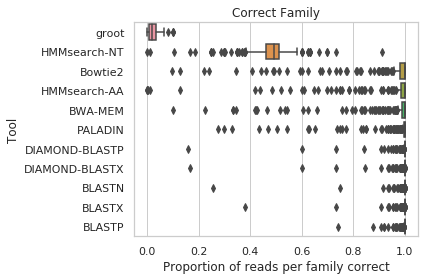

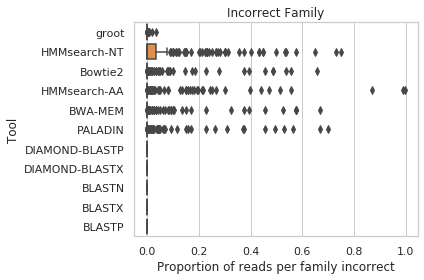

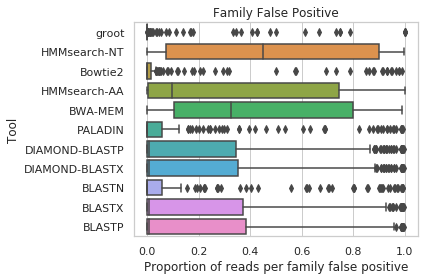

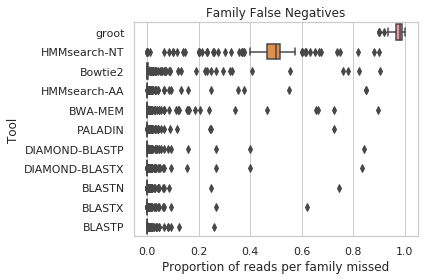

In [24]:

sns.boxplot(data = best_family_results_per_tool, x='correct_family_prop', y='tool', order=top_by_correct_fam_mean_order)
plt.title('Correct Family')
plt.xlabel('Proportion of reads per family correct')
plt.ylabel('Tool')
plt.tight_layout()
plt.savefig('figures/draft_figures/family_correct.png', dpi=300)
plt.show()

sns.boxplot(data = best_family_results_per_tool, x='wrong_family_prop', y='tool', order=top_by_correct_fam_mean_order)
plt.title('Incorrect Family')
plt.xlabel('Proportion of reads per family incorrect')
plt.ylabel('Tool')
plt.tight_layout()
plt.savefig('figures/draft_figures/family_wrong.png', dpi=300)
plt.show()

sns.boxplot(data = best_family_results_per_tool, x='fp_prop', y='tool', order=top_by_correct_fam_mean_order)
plt.title('Family False Positive')
plt.xlabel('Proportion of reads per family false positive')
plt.ylabel('Tool')
plt.tight_layout()
plt.savefig('figures/draft_figures/family_fp.png', dpi=300)
plt.show()

sns.boxplot(data = best_family_results_per_tool, x='missed_prop', y='tool', order=top_by_correct_fam_mean_order)
plt.title('Family False Negatives')
plt.xlabel('Proportion of reads per family missed')
plt.ylabel('Tool')
plt.tight_layout()
plt.savefig('figures/draft_figures/family_fn.png', dpi=300)

plt.show()

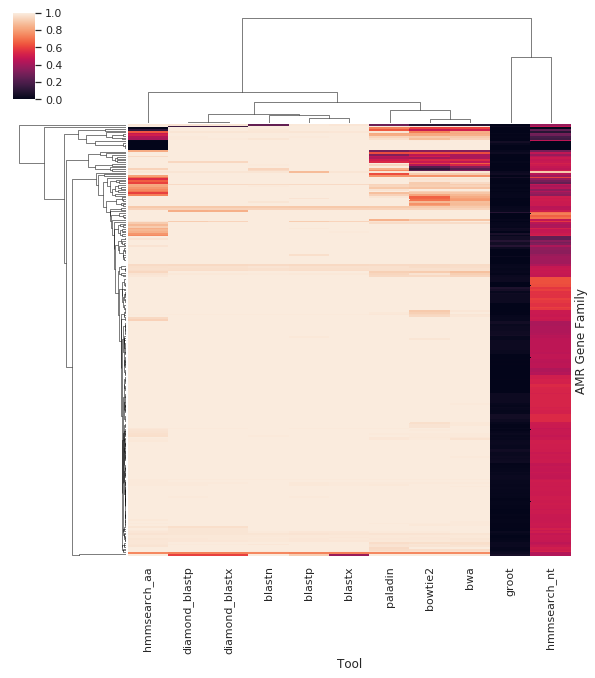

In [17]:
df = best_family_results_per_tool.rename(columns={'Family': 'AMR Gene Family', 'tool': "Tool"}).pivot('Tool', 'AMR Gene Family', 'correct_family_prop').fillna(0)
sns.clustermap(df.T, yticklabels=False)

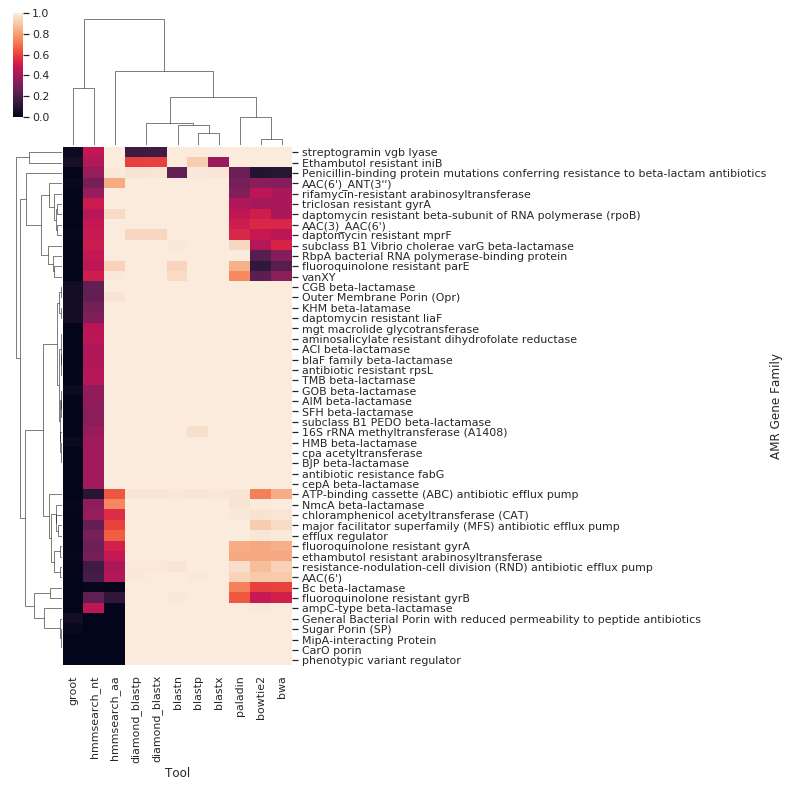

In [18]:
most_var = list(df.describe().T.sort_values('std', ascending=False).head(50).index)
sns.clustermap(df[most_var].T, yticklabels=True, figsize=(5,12))

/home/fin/miniconda3/envs/filtering/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


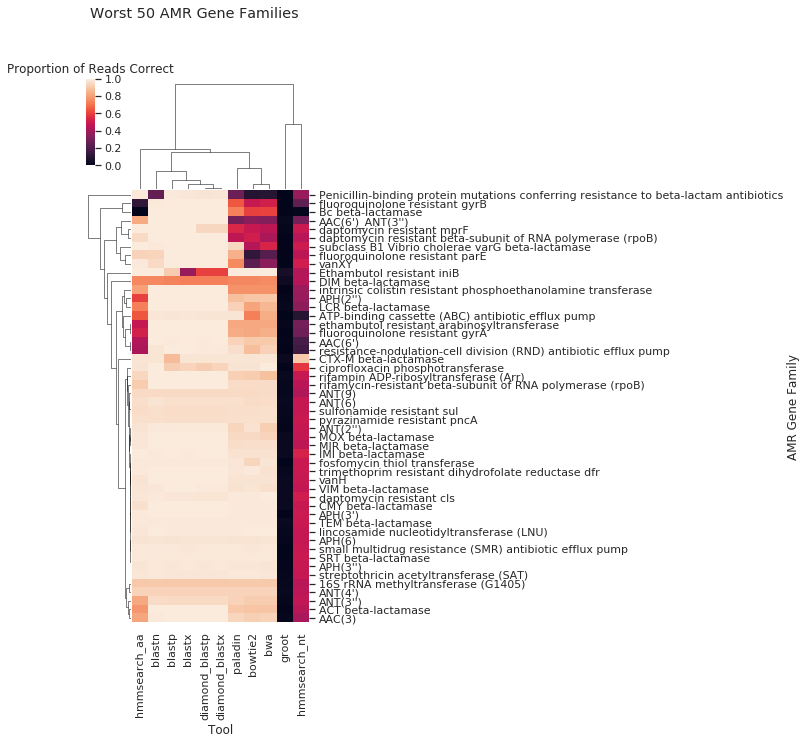

In [25]:
worst = list(df.describe().T.sort_values('50%').head(50).index)

sns.clustermap(df[worst].T, yticklabels=True, figsize=(4,10))
plt.title('Proportion of Reads Correct')
plt.suptitle('Worst 50 AMR Gene Families')
plt.tight_layout()
plt.savefig('figures/worst_families_heatmap.svg')

In [10]:
# now we want to see what the worst performing families are for each tool

In [11]:
card.family_sizes.most_common(10)

[('OXA beta-lactamase', 291),
 ('TEM beta-lactamase', 167),
 ('SHV beta-lactamase', 156),
 ('CTX-M beta-lactamase', 139),
 ('resistance-nodulation-cell division (RND) antibiotic efflux pump', 117),
 ('CMY beta-lactamase', 111),
 ('quinolone resistance protein (qnr)', 95),
 ('major facilitator superfamily (MFS) antibiotic efflux pump', 84),
 ("AAC(6')", 53),
 ('IMP beta-lactamase', 44)]

In [12]:
df = pd.read_csv('tool_runs/hmmsearch_nt_default_default.csv')
df[df['Unnamed: 0'].str.startswith('CMY')]

,Unnamed: 0,correct_family,wrong_family,false_positive,tool,params,totals,missed
42,CMY beta-lactamase,5040.0,139.0,235.0,hmmsearch_nt,default_default,10310.0,5131.0


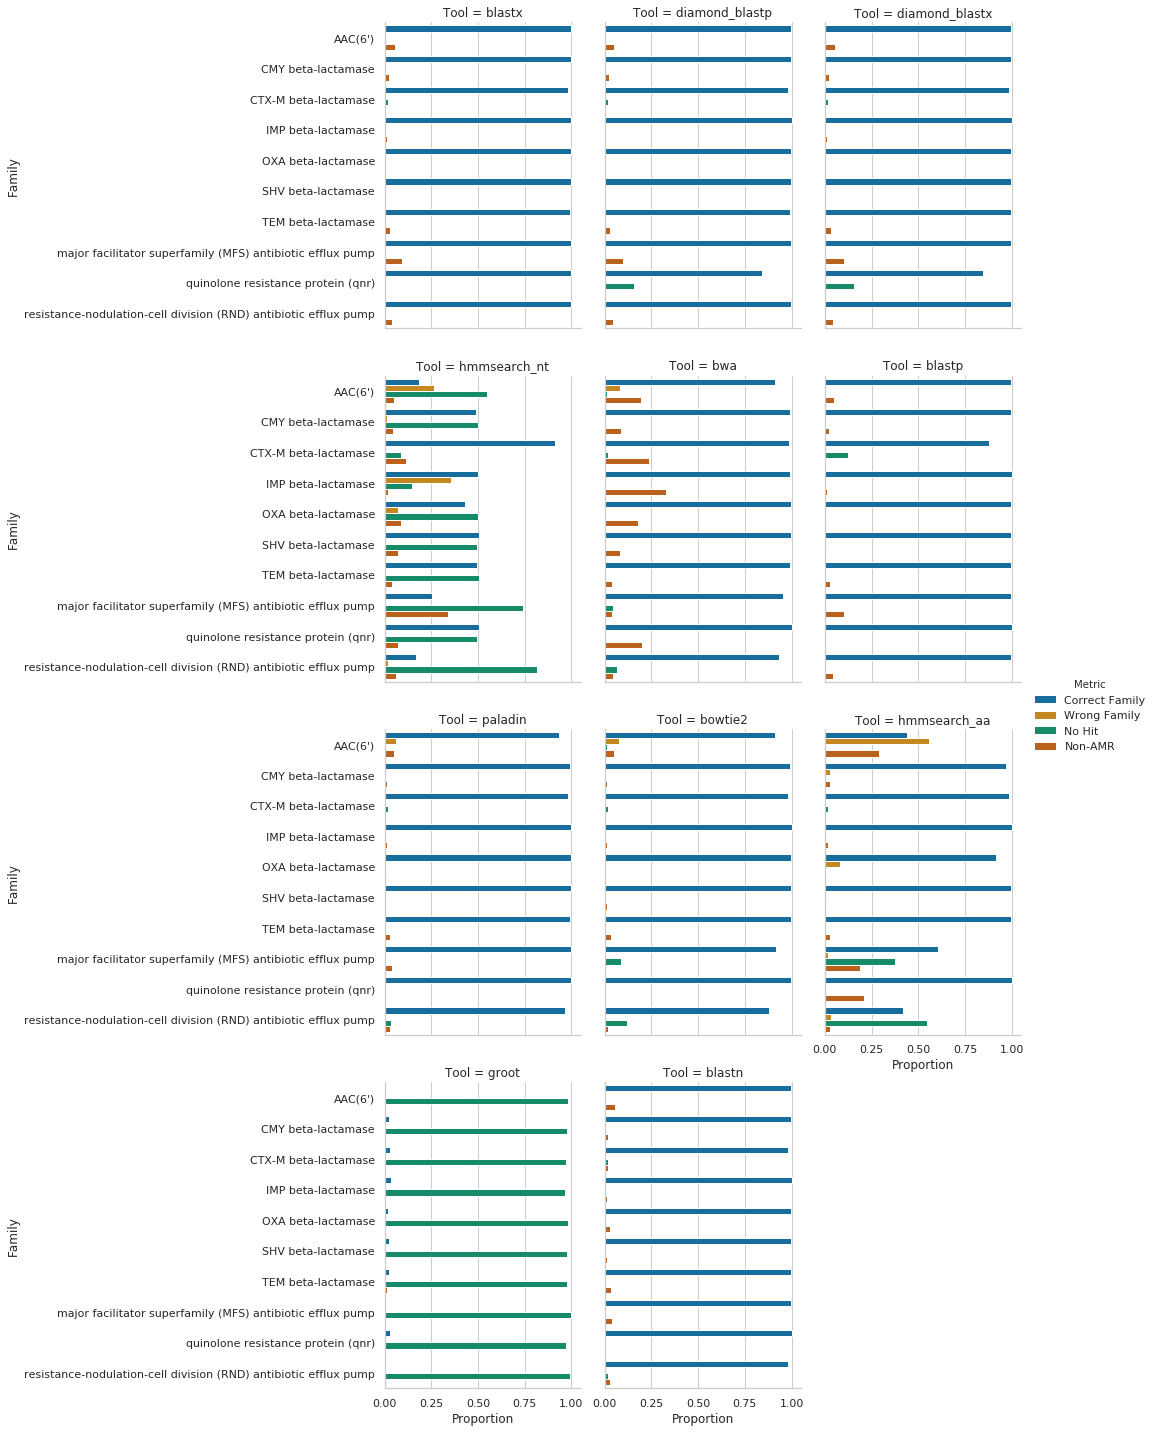

In [13]:
# just the 25 largest families 
biggest = [x[0] for x in card.family_sizes.most_common(10)]
big_families = best_family_results_per_tool[best_family_results_per_tool['Family'].isin(biggest)]
#sns.catplot(data = big_families, y='Family', x='correct_family_prop', kind='bar', col='tool', col_wrap=3)

sub_big_families = big_families[['Family', 'tool', 'correct_family_prop', 'wrong_family_prop', 'missed_prop', 'fp_prop']]#, 'missed_prop', 'fp_prop']]
melt_df = pd.melt(sub_big_families, id_vars=['Family', 'tool'], var_name='Metric', value_name='Proportion')

melt_df = melt_df.replace({'correct_family_prop': 'Correct Family',
                           'wrong_family_prop': 'Wrong Family',
                           'missed_prop': 'No Hit',
                           'fp_prop': 'Non-AMR'}).rename(columns={'tool': 'Tool'})

sns.catplot(data = melt_df, y='Family', x='Proportion', hue='Metric', kind='bar', col='Tool', col_wrap=3)
plt.savefig('figures/f4_biggest_families.svg')

In [14]:
# worst families per paradigm regardless of settings
worst = best_family_results_per_tool.set_index('Family').groupby(['tool'])['correct_family_prop'].nsmallest(5).reset_index()
worst.groupby('Family')['tool'].value_counts()

Family                                                                                 tool          
16S rRNA methyltransferase (G1405)                                                     blastn            1
                                                                                       blastp            1
                                                                                       blastx            1
AAC(6')                                                                                hmmsearch_nt      1
AAC(6')_ANT(3'')                                                                       bowtie2           1
                                                                                       bwa               1
                                                                                       paladin           1
ANT(4')                                                                                blastn            1
                                          

In [15]:
family_results['tool'].drop_duplicates()

0            blastn
0           bowtie2
0            blastx
0    diamond_blastp
0    diamond_blastx
0             groot
0            blastp
0      hmmsearch_nt
0      hmmsearch_aa
0               bwa
0           paladin
Name: tool, dtype: object

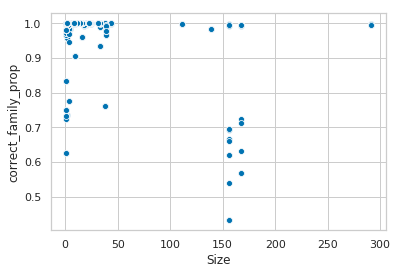

In [16]:
contam = pd.read_pickle('family_sequence_diversity/contamination_per_family.pkl')
contam = contam.rename(columns={'query_family': 'Family'})
contam = contam.set_index('Family')
contam['Size'] = pd.Series(card.family_sizes)
contam = contam.reset_index()

df = pd.merge(family_results.query('tool == "diamond_blastx"'), contam, on='Family')
df = df[df['Family'].str.contains('beta-lactamase')]
sns.scatterplot(data = df, y='correct_family_prop', x='Size') #='Normalised Bitscore Impurity')